# Extreme precipitation: Changes under climate scenarios worfklow [Risk assessment]
Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/HEAVY_RAINFALL/main?labpath=EXTREME_PRECIPITATION_Risk_Assessment.ipynb) to launch this notebook on MyBinder. <br>
Click [![Heavy Rainfall](https://img.shields.io/badge/HEAVY_RAINFALL-repository-blue)](https://github.com/CLIMAAX/HEAVY_RAINFALL/tree/main) to go to this workflow's GitHub repository.

## Risk Assessment Methodology
The risk assessment methodology in this notebook follows the guidelines within the CLIMAAX project and specifically the ones described [here](https://github.com/CLIMAAX/HEAVY_RAINFALL/blob/main/EXTREME_PRECIPITATION_Risk_workflow_description.md). Please take a look at this information before moving forward.
### Hazard
The changes in precipitation for specific durations, return periods, Global-Regional climate model pairs and RPCs (Representation Concentration Pathways) are provided at European scale. For this analysis EURO-CORDEX climate projections for precipitation flux at a 12km spatial resolution have been employed.

Refer to the [Hazard Assessment](https://github.com/CLIMAAX/HEAVY_RAINFALL/blob/main/EXTREME_PRECIPITATION_Hazard_Assessment.ipynb) notebook to investigate how to compute this indices with your own precipitation data.


### Exposure and vulnerability
Within the CLIMAAX project, different exposure and vulnerability datasets have been identified. For exposure, [Open Street Map](https://www.openstreetmap.org/copyright) offers a detailed description of infrastructure that can be overlayed to detect possible vulnerable locations in the future. Regarding vulnerability, age and sex can be retrieved from the [Worldpop](https://hub.worldpop.org/geodata/listing?id=87) dataset.

Refer to the Exposure and Vulnerability sections from the Handbook for more information on the datasets suggested within the CLIMAAX project. Feel free to incorporate them based on your research needs.

---

The following approach overlaps the chosen exposure and vulnerability datasets with the intensities generated in the [Hazard Assessment](https://github.com/CLIMAAX/HEAVY_RAINFALL/blob/main/EXTREME_PRECIPITATION_Hazard_Assessment.ipynb). To illustrate the application, we provide a **specific example for the Catalonia region in Spain**. Feel free to explore the code and modify it according to your specific research needs. 

---

## Prepare your workspace
:::{admonition} Find out about the Python libraries we will use in this notebook.
:class: hint dropdown

* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data.
* [osmnx](https://osmnx.readthedocs.io/en/stable/) - A Python package to easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap.
* [matplotlib](https://matplotlib.org/stable/) -  A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - A package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
* [contextily](https://contextily.readthedocs.io/en/latest/) - To retrieve matplotlib compatible tile maps from the internet.

### Load libraries

In [1]:
# Libraries to download data and manage files
import os
import requests
import zipfile
import glob
import osmnx

# Libraries for numerical computations, array manipulation and statistics.
import xarray as xr
import pandas as pd

# Libraries to handle geospatial data
import rioxarray as rio
import geopandas as gpd
import shapely import box

# Libraries to plot maps, charts and tables
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx

# Choosing the matplotlib backend
%matplotlib inline

### Setting your directory
The next cell will create the *extreme_precipitation_workflow* directory in the directory where the notebook is saved.

In [2]:
# Define the directory for the flashflood workflow
workflow_dir = 'extreme_precipitation_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
  os.makedirs(workflow_dir)
  os.makedirs(data_dir)
  os.makedirs(results_dir)


## Step 1: Select your analysis region

Before loading the hazard data, let us define the coordinates of our area of interest, in this case Catalonia. Based on these coordinates we will be able to clip the dataset for further processing.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com) to select a region and get the coordinates. Make sure to select _CSV_ in the lower left corner and copy the values in the brackets below.

:::{warning} 
If you are using the pre-computed rainfall intensities at European scale, please select a wider area than your municipality or city at first. In later steps, it will be possible to select a more specific domain.
:::

In [18]:
bbox = [0.5,40,4,43]; areaname = 'Catalonia'

## Step 2: Download and explore the hazard dataset

### European dataset
Execute the next cells in case you want to download the pre-computed European dataset for rainfall intensity. If that is not the case, please upload and read your own data in the corresponding section.

In [28]:
# How to download data from Cloud (waiting for implementation)

# Download the zip file
url_data = "http://gebrada.upc.es/climaax/heavy_rainfall_data.zip"
tmp_file = "heavy_rainfall_data.zip"
response = requests.get(url_data)
open(tmp_file, "wb").write(response.content)

# Unzip file to the data directory 
with zipfile.ZipFile(tmp_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Delete xip file
os.remove(tmp_file)

Expected rainfall intensities are provided for different combinations of EURO-CORDEX models, RCP's, time horizons and durations. Please choose from the options below to load the corresponding hazard file.
* Global Model: ICHEC-EC-EARTH,, MOHC-HADGEM
* RCP: 8.5
* Time horizon (year): 2040, 2070, 2100
* Duration (h): 3, 6, 12, 24
* Frequency/Return period (year): 2, 5, 10, 25, 100, 200

In [15]:
# Select from options
GCM = 'ICHEC-EC-EARTH'
RCP = 85
HORIZON = 2070
YEARS = [2005] + [HORIZON]
DURATION = 24
FREQUENCY = 100

In [93]:
# Load the hazard files (both reference and future)
f_idf_hist = glob.glob(os.path.join(data_dir, f'cordex_{GCM}', 'historical', f'idf_{DURATION}*2005.nc'))[0]
f_idf_proj = glob.glob(os.path.join(data_dir, f'cordex_{GCM}', f'rcp{RCP}', f'idf_{DURATION}*{HORIZON}.nc'))[0]

ds_idf = xr.open_mfdataset([f_idf_hist,f_idf_proj], decode_coords='all')

In [94]:
# Get dataset's CRS as string
crs_hazard_str = ds_idf.rotated_latitude_longitude.crs_wkt
crs_hazard = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

# Clip dataset to the selected area and remove extra indexes.
ds_idf_area = ds_idf.rio.clip_box(*bbox, crs="EPSG:4326").sel(ci='value', duration = DURATION, drop = True)

Save the clipped datasets to netCDF's files in your data directory so that you can also explore this data in any GIS application.

In [97]:
# Save as netCDF files in the data directory. 
for year in YEARS:
    f_idf = os.path.join(data_dir, f'idf_{DURATION}h_{GCM}_{year}_{areaname}.nc')
    ds_idf_area.sel(time = ds_idf.time.dt.year.isin(year)).to_netcdf(f_idf)

Let's visualize the hazard map for the combination chosen. Modify the palette's colors and thresholds to your preference.

In [21]:
# Plot the data to visualize hazard data for the region
# Colormap definition for expected intensity values
pal_thresh = [0., 25, 50, 75, 100, 125, 150, 175, 200, 225., 250., 275., 300., 325., 350., 375., 400, 500]
pal_rgb = ['#ffffff00', '#d6e2ffff', '#8db2ffff', '#626ff7ff', '#0062ffff', '#019696ff', '#01c634ff',
           '#63ff01ff', '#c6ff34ff', '#ffff02ff', '#ffc601ff', '#ffa001ff', '#ff7c00ff', '#ff1901ff', '#a20a28ff',
           '#9b159dff', '#d294d3ff', '#f6e9f6ff']
cmap, norm = from_levels_and_colors(pal_thresh, pal_rgb, extend='max')

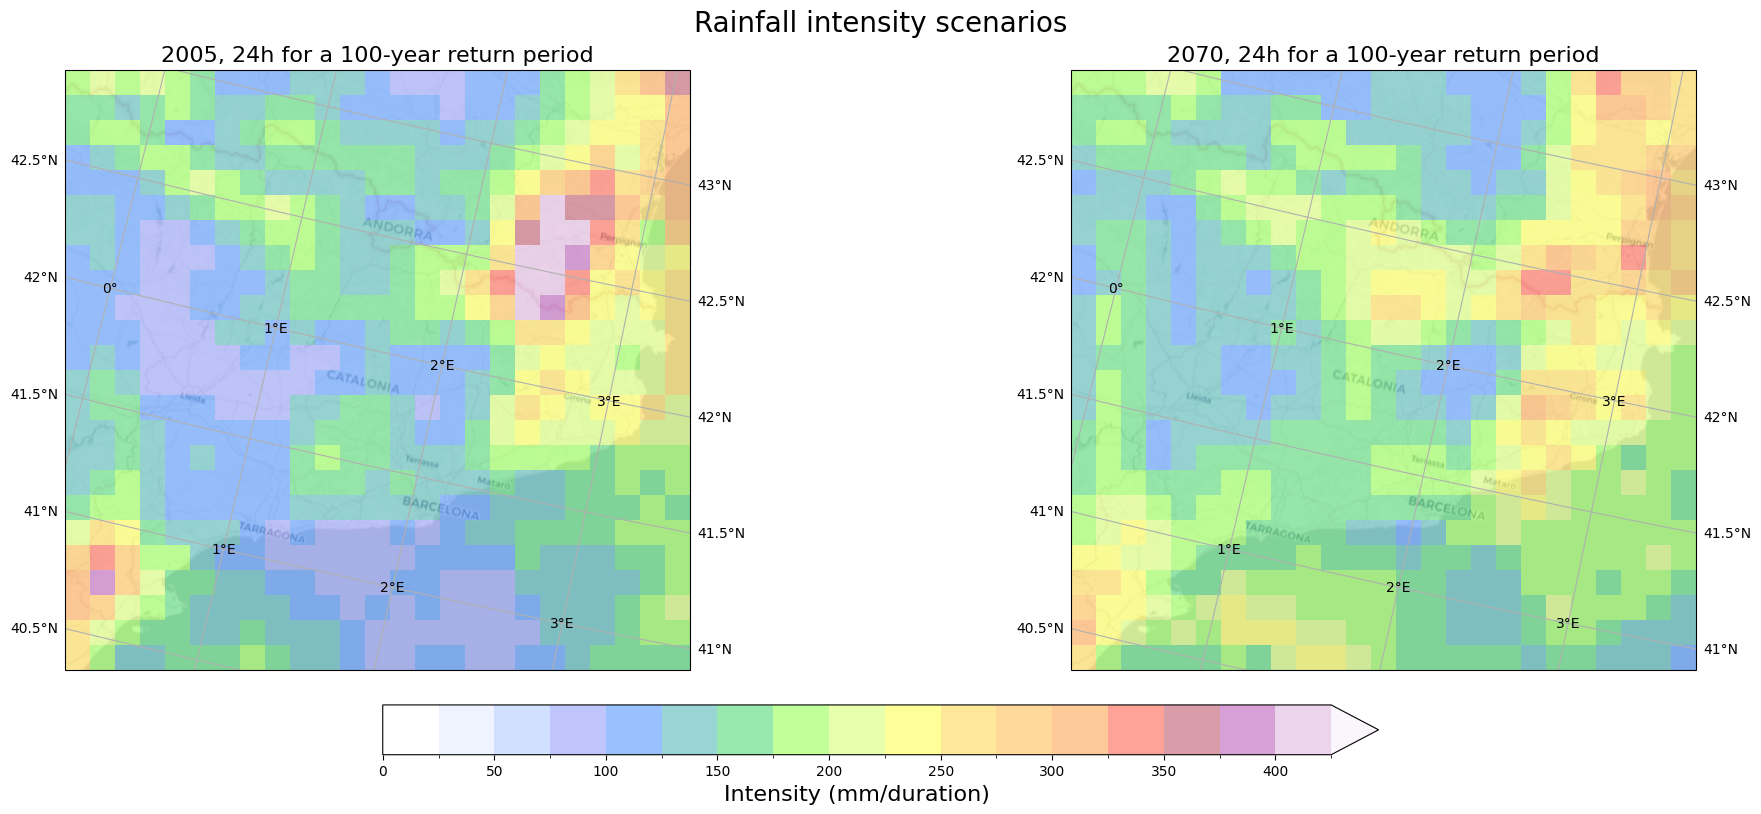

In [45]:
fig, ax = plt.subplots(ncols = len(YEARS), nrows = 1, figsize=(20,8), layout="constrained",
                       subplot_kw={'projection': crs_hazard});

for i, year in enumerate(YEARS):
    da = ds_idf.sel(frequency=FREQUENCY, time = ds_idf.time.dt.year.isin(year)).idf
    im = da.plot(ax = ax[i], norm = norm, cmap=cmap, alpha = 0.4,
                                                   add_colorbar=False);
    ctx.add_basemap(ax=ax[i], crs=crs_hazard, source=ctx.providers.CartoDB.Positron,
               attribution = False)
    ax[i].gridlines(draw_labels=True)
    ax[i].set_title(f'{year}, {DURATION}h for a {FREQUENCY}-year return period', fontsize= 16)

fig.suptitle('Rainfall intensity scenarios', fontsize=20)
cbar = fig.colorbar(im, ax=ax[:], location = 'bottom', shrink = 0.5)
cbar.set_label('Intensity (mm/duration)', fontsize = 16)

Execute the next cell to save the plot in your results directory.

In [ ]:
# To save the plotted image in your directory uncomment the next line.
fig.savefig(os.path.join(results_dir, f'Rainfall_intensity_scenario_{YEARS[0]}_{YEARS[1]}.png')

### Local hazard dataset
:::{hint}
In case you want to use your own hazard data, use the next code snippet to read and process it.
In order to read raster data, either ```rasterio```, ```xarray``` or ```rioxarray``` can be used.
:::

In [6]:
# Read your own data for expected rainfall intensities (OPTIONAL).
ds = ...
# Clip to the selected area and plot the data (See cells above)
ds_local = ...

## Step 3: Define your specific analysis area
Before downloading exposure and vulnerabily data, let's define more specifically the area of interest following the same approach as before.

In [ ]:
bbox_EV = [2.392073,41.513521,2.478418,41.563406]; areaname_EV = 'Mataro'

Let's clip again the hazard dataset. Due to its coarse resolution, it is possible that just a few pixels are selected.

In [ ]:
for year in YEARS:
    f_idf = os.path.join(data_dir, f'idf_{DURATION}h_{GCM}_{year}_{areaname}.nc')
    ds_idf_area = xr.open_dataset(f_idf, decode_coords = 'all')
    ds_idf_local = ds_idf_area.sel(time = ds_idf_area.time.dt.year.isin(year)).rio.clip_box(*bbox_EV, crs="EPSG:4326", auto_expand = True)
    ds_idf_local.to_netcdf(f_idf.replace(areaname, areaname_EV))

## Step 3: Download and explore the exposure and vulnerability datasets.

### Exposure
To download data from Open Street Map (OSM), the Python library ```osmnx``` will be used. It offers the possibility to select which kind of data is downloaded by _tags_. In this example, we will focus on hospitals and education facilities. 

:::{note}
Feel free to modify the code in order to download the desired type of infrastructure. Documentation of OSM tags can be found [here](https://wiki.openstreetmap.org/wiki/Tags).
:::

In [9]:
### Download OSM data and classify it.
# Create an OSM directory within the data directory.
OSM_dir = os.path.join(data_dir, 'OSM')
os.makedirs(OSM_dir, exist_ok = True)

In [37]:
# Define what infrastructures are downloaded.
TAGS = {'amenity' : ['school', 'university', 'college', 'kindergarten', 'hospital']           
}
# The bbox of OSM is defined with EPSG 4326 as North, South, East, West.
gdf_OSM = osmnx.features_from_bbox(bbox = (bbox_EV[3],bbox_EV[1],bbox_EV[2],bbox_EV[0]), tags = TAGS)

In [38]:
# Keep only the name, amenity and geometry columns.
gdf_OSM = gdf_OSM[['name', 'amenity', 'geometry']]
# Keep only infrastructures defined by a polygon.
gdf_OSM = gdf_OSM[gdf_OSM.geom_type.isin(['Polygon'])]
# Reformat list items to write ShapeFile
gdf_OSM = gdf_OSM.map(lambda x: str(x) if isinstance(x, list) else x)

In [ ]:
# Reproject OSM data to hazard's CRS.
gdf_OSM_reprojected = gdf_OSM.to_crs(crs = crs_hazard)

# Save geoDataFrame to the data directory.
f_OSM_local = os.path.join(OSM_dir, f'OSM_{areaname_EV}.shp')
gdf_OSM_reprojected.to_file(f_OSM_local, driver='ESRI Shapefile')

Let's visualise these infrastructures over a map.

In [20]:
crs_hazard = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
crs_hazard_str = crs_hazard.to_string()

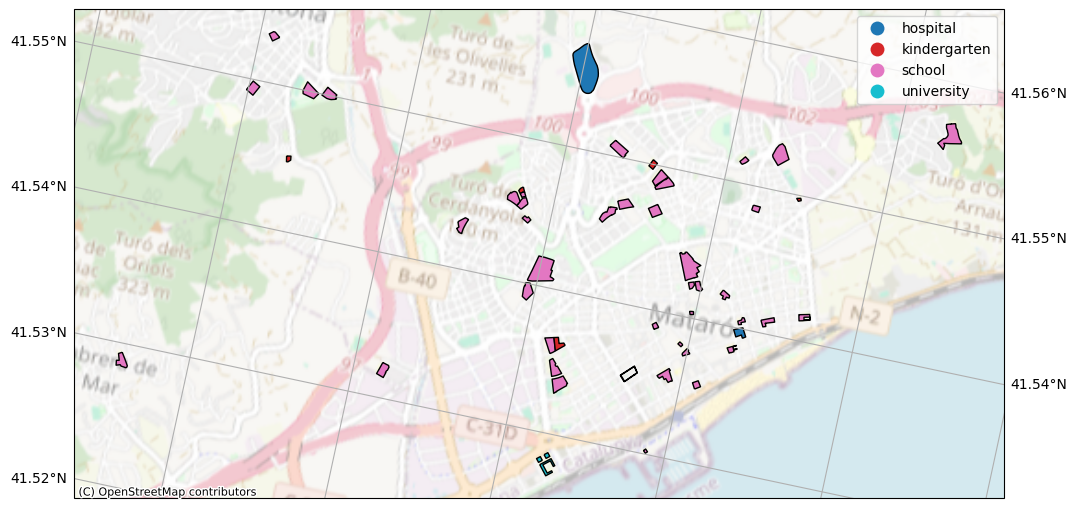

In [176]:
# Visualise the exposure data.
gdf_OSM = gpd.read_file(f_OSM_local)
# Create figure and 
fig, ax = plt.subplots(figsize = (12,12), subplot_kw={'projection': crs_hazard})
gdf_OSM.plot(ax = ax, column = 'amenity', legend = True, edgecolor = 'black')
# Add gridlines and OSM basemap
ax.gridlines(draw_labels=True)
ctx.add_basemap(ax = ax, crs=crs_hazard_str, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

### Vulnerability
The population and demographic data can be obtained from the [WorldPop data portal](https://hub.worldpop.org/doi/10.5258/SOTON/WP00695) where it is classified by countries and available to download in Geotiff format at a resolution of 3 arc seconds (approximately 100m at the equator). For this example, *children* (< 15y) and *elderly* (> 65y) categories will be considered as phisically susceptible to the hazard and will be download only for Spain.

:::{hint}
Check how the data is indexed [here](https://data.worldpop.org/GIS/AgeSex_structures/) to define the specific URL before downloading.
:::

In [41]:
# Define categories based on WorldPop data
age_categories = {
    'children' : [0, 1, 5, 10],
    'elderly' : [65, 70, 75, 80]
}

In [ ]:
# Download files from WorldPop portal
pop_base_url = 'https://data.worldpop.org/GIS/AgeSex_structures/Global_2000_2020_Constrained/2020/ESP/'
for age in [0, 1, 5, 10, 65, 70, 75, 80]:
    for gender in ['f', 'm']:
        file = f'esp_{gender}_{age}_2020_constrained.tif'
        url_data = pop_base_url + file
        response = requests.get(url_data)
        open(os.path.join(data_dir, file), "wb").write(response.content)

In the following cells, we will clip each file to the selected area, aggregate the population by the categories defined above and reproject them to the hazard's CRS.

In [ ]:
population_categories = {}
for group, ages in age_categories.items():
    file_i = f'pop_2020_{group}_{areaname_EV}.tif'
    ds_i = None
    for age in ages:
        for gender in ['f', 'm']:
            file_ii = f'esp_{gender}_{age}_2020_constrained.tif'
            file_path_ii = os.path.join(data_dir, file_ii)
            ds_ii = rio.open_rasterio(file_path_ii)
            # Clip data to area.
            ds_ii = ds_ii.rio.clip_box(*bbox_EV, crs="EPSG:4326")
            if ds_i is None:
                ds_i = ds_ii.where(ds_ii != ds_ii.rio.nodata, 0)
            else:
                ds_i += ds_ii.where(ds_ii != ds_ii.rio.nodata, 0)
    population_categories[group] = int(ds_i.sum())
    ds_i = ds_i.where(ds_i != 0, ds_ii.rio.nodata)
    ds_i.assign_attrs(ds_ii.attrs)
    ds_i = ds_i.rio.reproject(dst_crs = crs_hazard)
    ds_i.rio.write_crs(crs_hazard, inplace = True)
    ds_i.rio.to_raster(os.path.join(data_dir, file_i))

del ds_i, ds_ii

# Sum population within both age groups
pop_elderly = rio.open_rasterio(f'{data_dir}/pop_2020_elderly_{areaname_EV}.tif', masked = True)
pop_children = rio.open_rasterio(f'{data_dir}/pop_2020_children_{areaname_EV}.tif', masked = True)

pop_vulnerable = pop_children.where(pop_children.notnull(), 0) + pop_elderly.where(pop_elderly.notnull(), 0)

# Save new raster file
f_pop_vulnerable = f'{data_dir}/pop_2020_vulnerable_{areaname_EV}.tif'
pop_vulnerable.rio.to_raster(f_pop_vulnerable)

In [519]:
# Write and save aggregate population over the whole region.
df_population = pd.Series(population_categories,
            index = population_categories.keys()).rename_axis('Physical susceptibility').to_frame(name = 'Nº of people')

f_population = f'pop_2020_{areaname_EV}.csv'
df_population.to_csv(os.path.join(data_dir, f_population))

Let's visualize this population data.

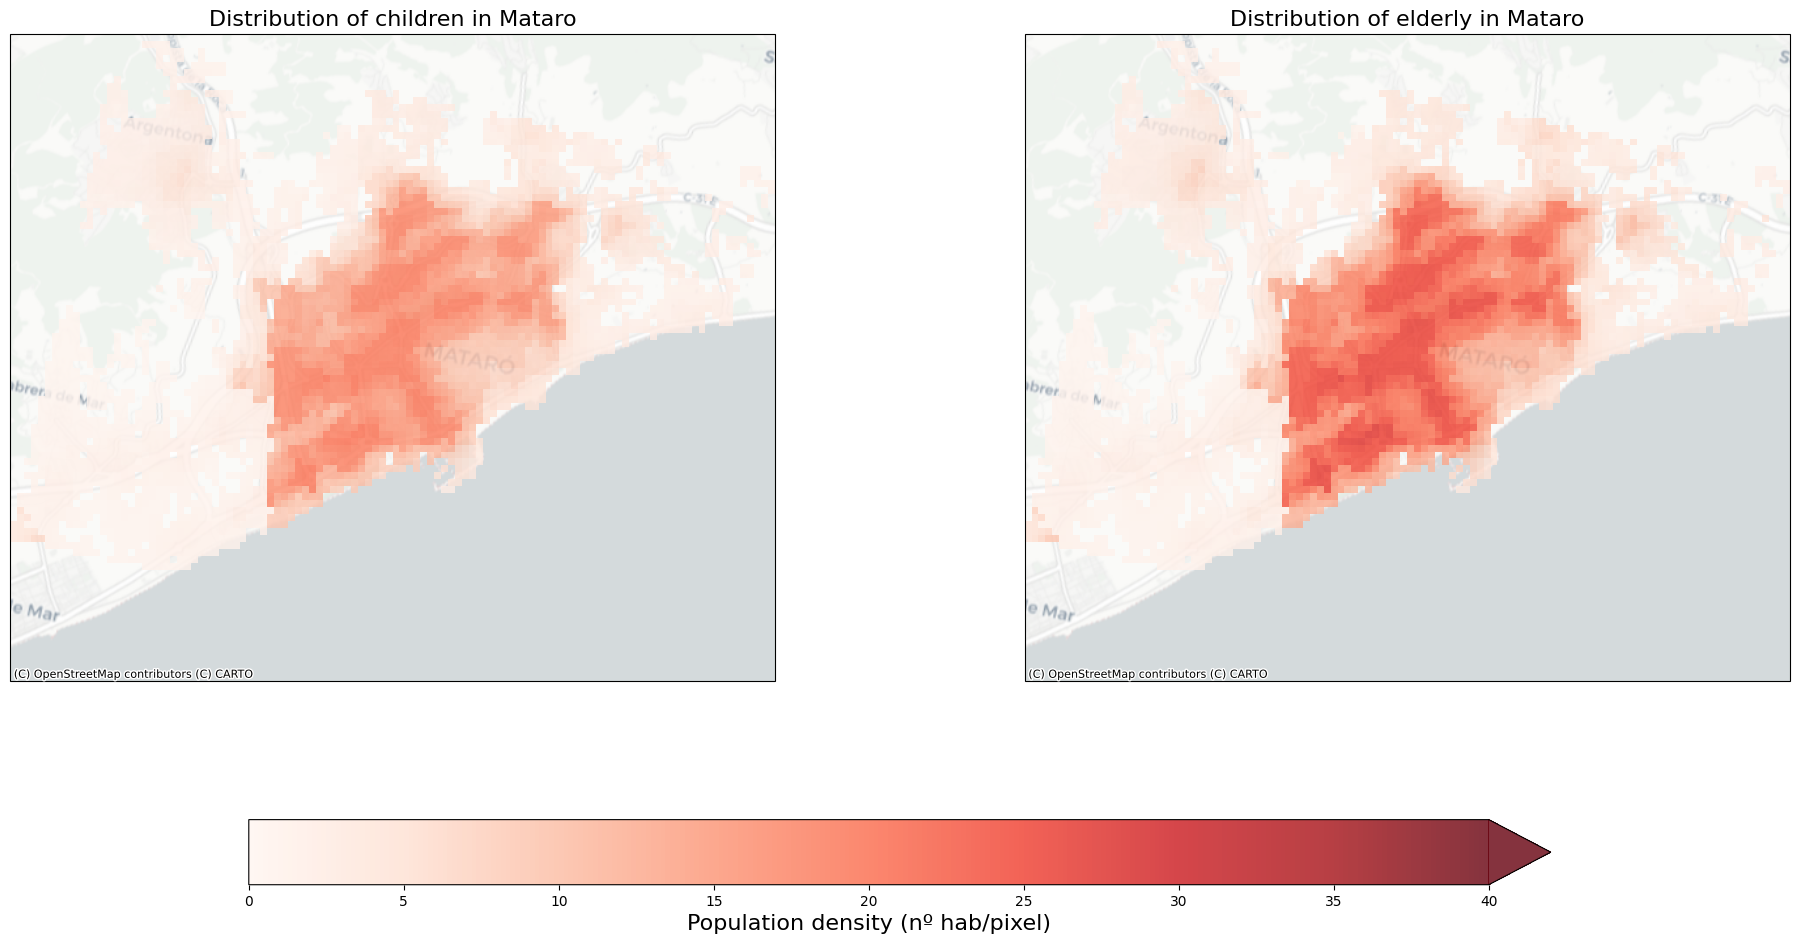

In [111]:
fig, axes = plt.subplots(1,2, figsize = (24,12), subplot_kw={'projection': crs_hazard})
for i, group in enumerate(list(age_categories.keys())):
    path_i = os.path.join(data_dir, f'pop_2020_{group}_{areaname_EV}.tif')
    ds_i = rio.open_rasterio(path_i)
    im = ds_i.where(ds_i > 0).plot(ax = axes[i], cmap = 'Reds', add_colorbar = False, vmin = 0, vmax = 40, alpha = 0.8)
    ctx.add_basemap(ax = axes[i], crs=crs_hazard, source=ctx.providers.CartoDB.Positron)
    axes[i].set_title(f'Distribution of {group} in {areaname_EV}', fontsize = 16)
cbar_pop = fig.colorbar(im, ax = axes[:], shrink = 0.7, location = 'bottom', extend = 'max')
cbar_pop.set_label('Population density (nº hab/pixel)', fontsize = 16)

## Step 4: Combine hazard with exposure and vulnerability
Overlaying the hazard maps with the infrastructures selected above shows which locations will be affected by a change in rainfall intensity under climate scenarios.

In [157]:
# Load hazard data
f_idf_local = [os.path.join(data_dir, f'idf_{DURATION}h_{GCM}_{year}_{areaname_EV}.nc') for year in YEARS]
ds_idf_local = xr.open_mfdataset(f_idf_local, decode_coords = 'all')

In [158]:
# Load exposure data
f_OSM_local = os.path.join(OSM_dir, f'OSM_{areaname_EV}.shp')
gdf_exposure_local = gpd.read_file(f_OSM_local)

In [159]:
# Load vulnerability data
f_pop_vulnerable = f'{data_dir}/pop_2020_vulnerable_{areaname_EV}.tif'
ds_pop_vulnerable = rio.open_rasterio(f_pop_vulnerable)

In [160]:
# Acces bounding box in data's CRS.
r_bbox = ds_pop_vulnerable.rio.bounds()

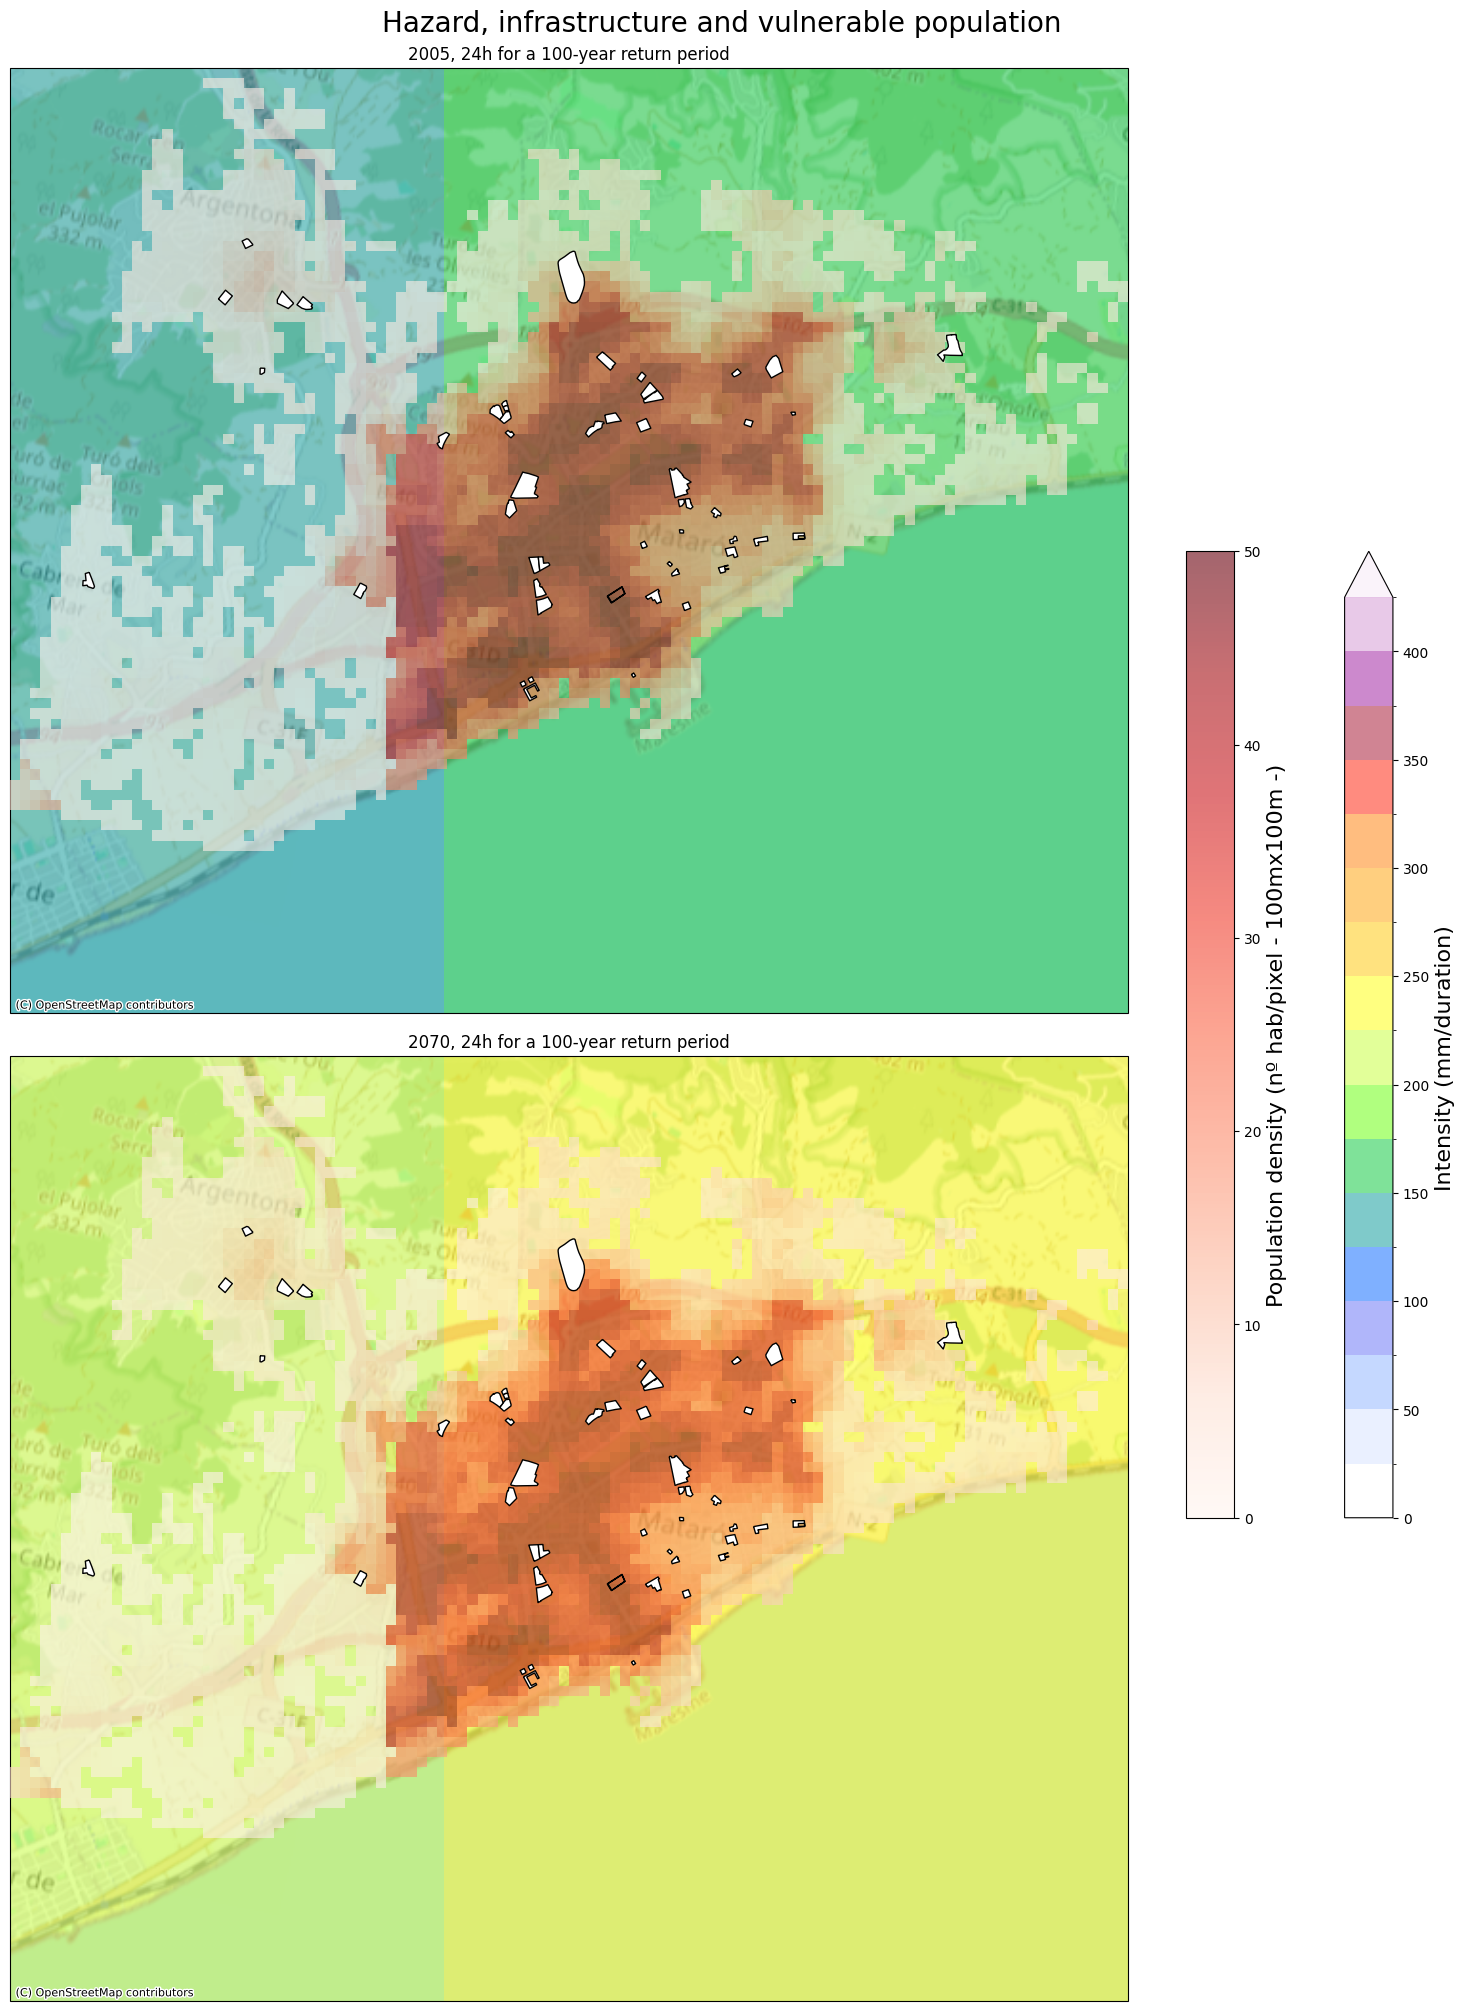

In [199]:
# Plot for options selected.

crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

fig_all, axes_all = plt.subplots(len(YEARS), 1, figsize = (15,20), layout="constrained",
                       subplot_kw={'projection': crs})

for i, year in enumerate(YEARS):
   
    # Hazard
    da = ds_idf_local.sel(frequency = FREQUENCY, time = ds_idf.time.dt.year.isin(year)).idf
    im_rainfall = da.plot(ax = axes_all[i], norm = norm, cmap=cmap, alpha = 0.5,
                      add_colorbar=False, xlim = [r_bbox[0],r_bbox[2]], ylim = [r_bbox[1],r_bbox[3]],zorder = 2)

    # Vulnerable population
    im_pop = ds_pop_vulnerable.where(ds_pop_vulnerable > 0).plot(ax = axes_all[i], alpha = 0.6, cmap = 'Reds', vmin = 0, vmax = 50, add_colorbar = False, zorder = 3)
    
    # Infrastructure
    gdf_exposure_local.plot(ax = axes_all[i], legend = False, zorder = 4, color='white', edgecolor='black')

     # Basemap
    ctx.add_basemap(ax = axes_all[i], crs=crs_hazard, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.8, zorder = 1)
    

    # Subplots title
    axes_all[i].set_title(f'{year}, {DURATION}h for a {freq}-year return period')
     
fig_all.suptitle('Hazard, infrastructure and vulnerable population', fontsize = 20);
cbar_rainfall = fig_all.colorbar(im_rainfall, ax=axes_all[:], location = 'right', shrink = .5);
cbar_rainfall.set_label('Intensity (mm/duration)', fontsize = 16);

cbar_pop= fig_all.colorbar(im_pop, ax=axes_all[:], location = 'right', shrink = .5);
cbar_pop.set_label('Population density (nº hab/pixel - 100mx100m -)', fontsize = 16);

In [ ]:
# Save the plot above as a png in your results directory.
fig_all.savefig(os.path.join(results_dir, f'Hazard_infrastrucutre_vpopulation_{YEARS[0]}_{YEARS[1]}.png')

Next cell generates a summary of the plot above with absolute values for exposed infrastructure and vulnerable population defined in previous steps.

In [485]:
# Get absolute bounds of hazarad dataset.
xmin, ymin, xmax, ymax = ds_idf_local.rio.bounds()

# Compute the size of each pixel
nx = da.rlon.size
dx = (xmax-xmin)/nx

ny = da.rlat.size
dy = (ymax-ymin)/ny

print("\n" + "Vulnerable population (nº)"+" "*5+"Infrastructure (nº)"+" "*5+"Rainfall intensity in 2005" + " "*5 +  "Rainfall intensity in 2070" + "\n" )
# For each hazar pixel, get sum of people and buildings exposed.
for i in range(nx):
    for j in range(ny):
        xmin_ij = xmin + dx*i
        xmax_ij = xmin + dx*(i+1)
        ymin_ij = ymin + dy*j
        ymax_ij = ymin + dy*(j+1)

        bbox_ij = box(xmin_ij, ymin_ij, xmax_ij, ymax_ij,ccw = False)
        pop_ij = ds_pop_vulnerable.sel(y = slice(ymax_ij,ymin_ij), x = slice(xmin_ij, xmax_ij))
        if pop_ij.x.size and pop_ij.y.size:
            print(int(pop_ij.band_data.sum().values), " "*30, sum(bbox_ij.contains(gdf_exposure_local.geometry)), 
                         " "*25, ds_idf_local.sel(frequency = FREQUENCY).isel(time = 0,rlat = j, rlon = i).idf.values.round(), "mm",
                 " "*20, ds_idf_local.sel(frequency = FREQUENCY).isel(time = 1,rlat = j, rlon = i).idf.values.round(), "mm")


Vulnerable population (nº)     Infrastructure (nº)     Rainfall intensity in 2005     Rainfall intensity in 2070

12003                                7                           144.0 mm                      207.0 mm
46919                                44                           154.0 mm                      241.0 mm


:::{admonition} GIS tips to further analyse data
:class: tip dropdown

All files generated in the previous steps can also be viewed and explored with a GIS application. For example:

* Drawn-on-map areas can be extracted from original rasters with ```Raster extraction```.
* Raster analysis such as layer statistics and calculations are easily executed with the ```Processing toolbox```.

## Conclusions
This workflow demonstrates the local implementation of the Extreme Precipitation Risk Assessment.

---

## Authors
The Center of Applied Research in Hydrometrology from the Universitat Politècnica de Catalunya (CRAHI-UPC). The members involved in the development of this workflow were the following (alphabetic order):
 
Marta Gabarró Solanas<br>
Víctor González<br>
Erika R. Meléndez-Landaverde<br>
Daniel Sempere-Torres

--- 